# 12. Runge-Kutta method, Version 2,  d/dt function separated out

In verison 1 of our projectile code, we've made it to work, using both Euler's method and the RK2 method. But as we'll see later, the structure of the code has a lot of room for improvement. Before moving on to version 2, let's save this script as version 1 – this is the most explicit version we will ever see, so if you ever get lost in the abstractions in versions 2 and 3 later on, you can always revert back to this version to review the detailed workflow of the calculation.

Moving on to version 2 now. If you stare at the code for long enough, you may realize that the calculation of acceleration appears two times – once in Euler's method and once in RK2. In version 2 we will try to define this calculation only once. This is done by the the diffeq() function below.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Physical parameters (carry these forward from Notebook 11) ---
g   = 9.8   # gravitational acceleration (m/s^2)
b   = 1.0   # drag coefficient (1/s)
dt  = 0.1   # timestep for Euler and RK2 (s)
dt_ref = 0.00005  # tiny timestep for reference Euler solution

### ✏️ Checkpoint: Spotting Repeated Code

Look at the `move_Euler` and `move_RK2` functions from Notebook 11.

**Q1.** Which calculation appears in *both* functions?

**Q2.** If you wanted to change the physics — say, use quadratic drag (`acc = -b * v²` instead of `-b * v`) — how many places in the code would you need to edit?

**Q3.** What is the advantage of defining the acceleration calculation in a single separate function called `diffeq()`?

*Write your answers below, then implement `diffeq()` in the next cell.*

In [ ]:
# Checkpoint answers
# Q1:xacc = -b*xvel and zacc = -g-b*zvel
# Q2:Two places for Euler, Four places for Runge-Kutta.
# Q3:Less lines of codes, stream-lines the process

In [ ]:
# diffeq() computes the time derivative of every state variable.
# It takes the current state (positions + velocities) and returns
# the corresponding rates of change (velocities + accelerations).
#
# Return order: (d(xpos)/dt, d(xvel)/dt, d(zpos)/dt, d(zvel)/dt)
#             = (xvel,       xacc,        zvel,       zacc      )

def diffeq(xpos, xvel, zpos, zvel):
    # TODO: compute accelerations using the physics from Notebook 11
    xacc = -b*xvel    # horizontal: drag only
    zacc = -g-b*zvel   # vertical: gravity + drag

    # Return derivatives in order: velocity then acceleration for each axis
    return xvel,xacc,zvel,zacc

In [ ]:
def move_Euler(xpos, xvel, zpos, zvel, dt):
    # diffeq gives all time derivatives at once — this is now complete
    xvel_d, xacc, zvel_d, zacc = diffeq(xpos, xvel, zpos, zvel)
    xpos = xpos + xvel_d * dt
    xvel = xvel + xacc  * dt
    zpos = zpos + zvel_d * dt
    zvel = zvel + zacc  * dt
    return xpos, xvel, zpos, zvel

# TODO: Complete move_RK2 by filling in the blanks.
def move_RK2(xpos, xvel, zpos, zvel, dt):
    # Call diffeq() at the start to get derivatives at time t
    xvel_d, xacc, zvel_d, zacc = diffeq(xpos, xvel, zpos, zvel)

    # Propagate to the midpoint (t + dt/2)
    xpos_half = xpos + xvel_d * dt/2
    xvel_half = xvel + xacc * dt/2
    zpos_half = zpos + zvel_d * dt/2
    zvel_half = zvel + zacc * dt/2

    # Call diffeq() again at the midpoint state
    xvel_hd, xacc_h, zvel_hd, zacc_h = diffeq(xpos_half, xvel_half, zpos_half, zvel_half)

    # Update to t + dt using midpoint derivatives
    xpos = xpos + xvel_hd * dt
    xvel = xvel + xacc_h * dt
    zpos = zpos + zvel_hd * dt
    zvel = zvel + zacc_h * dt
    return xpos, xvel, zpos, zvel

Does the code look more organized? We can now clearly see the structure of the two ODE solver methods. The function diffeq() essentially serves to calculate the time derivative of every variable – in intakes positions and velocities and returns velocities and accelerations.

In Euler, we call diffeq() once and propagate time by $dt$. In RK2, we call diffeq() once, propagate time by $dt/2$, call diffeq() a second time, and propagate time by dt. The better accuracy of RK2 comes at the price of twice as many calculations (compared to what is needed for Euler). This concludes version 2.

Now seeing that the structure contains blocks of something = something + \[something's time derivative\] $\times dt$, we're curious if these blocks can be compacted even further. This is what we'll do in version 3. Our goal is to write everything as a vector like y = [xpos, xvel, zpos, zvel], and ydot = [xvel, xacc, zvel, zacc], so that instead of writing

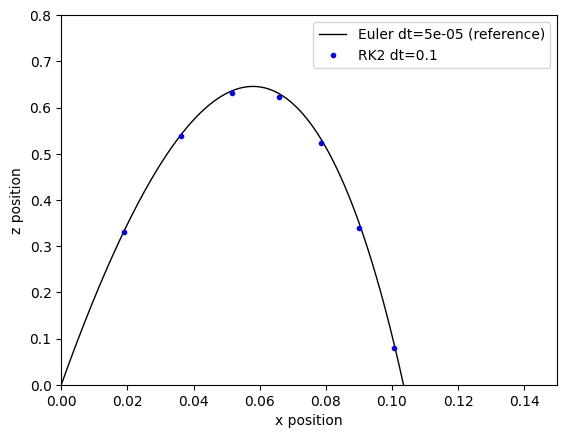

In [ ]:
# --- Run and verify your move_RK2 implementation ---
# Uses the analytic solution as a reference.

t_max = 2.0
xvel0, zvel0 = 0.2, 4.0

# Analytic solution at fixed checkpoints
t_check = np.arange(0, t_max, dt)
z_analytic = (zvel0 + g/b) / b * (1 - np.exp(-b * t_check)) - g * t_check / b

# Run RK2
xpos=0; xvel=xvel0; zpos=0; zvel=zvel0
xr=[]; zr=[]
t = 0.0
while t < t_max:
    xpos, xvel, zpos, zvel = move_RK2(xpos, xvel, zpos, zvel, dt)
    if zpos < 0:
        break
    xr.append(xpos); zr.append(zpos)
    t += dt

# Run Euler reference (small dt)
xpos=0; xvel=xvel0; zpos=0; zvel=zvel0
xe=[]; ze=[]
t = 0.0
while t < t_max:
    xpos, xvel, zpos, zvel = move_Euler(xpos, xvel, zpos, zvel, dt_ref)
    if zpos < 0:
        break
    xe.append(xpos); ze.append(zpos)
    t += dt_ref

fig, ax = plt.subplots()
ax.plot(xe, ze, 'k-', lw=1, label=f'Euler dt={dt_ref} (reference)')
ax.plot(xr, zr, 'b.', label=f'RK2 dt={dt}')
ax.set_xlim(0, 0.15); ax.set_ylim(0, 0.8)
ax.set_xlabel('x position'); ax.set_ylabel('z position')
ax.legend()
plt.show()

Instead of writing four separate update lines like this:

```python
xpos = xpos + xvel * dt
xvel = xvel + xacc * dt
zpos = zpos + zvel * dt
zvel = zvel + zacc * dt
```

we can simply write

In [ ]:
y = y + ydot * dt

But we need the right python tools to write things in such a vectorized way and carry out vector operations. For that we'll need numpy arrays.

## Numpy arrays
Numpy arrays is another important utility of the numpy module that make numerical simulations much easier to perform. Numpy arrays can be thought of as lists composed by elements all of the same type. Let's fire up numpy first as usual, if you haven't done so already. We can then generate arrays of any given length by using np.array() on a list

In [ ]:
import numpy as np
np.array([1, 2, 5])

array([1, 2, 5])

There are also other numpy functions that automatically creates special vectors for you. For example, you can create arrays with all values of zero, using the numpy.zeros() function. An integer argument to the function specifies the number of elements in the array.

In [ ]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In the same way, we can create arrays with all values of one, using the numpy.ones() function.

In [ ]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

You can also create multidimensional arrays (a.k.a. nested arrays) that represents matrices with two integers.

In [ ]:
np.zeros((4,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
np.zeros((3,3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
np.ones((3,3))

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

Another useful function is numpy.eye(), (as in the pronunciation of $I$, the identity matrix) to create identity matrices

In [ ]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

If you haven't noticed this earlier, we've been already working with some numpy arrays previously. Earlier we've used np.arange() and np.linspace() to create a range of numbers – they actually produce numpy arrays. You can verify that using the type() function.

In [ ]:
a = np.linspace(0,10,11)
print(a,  type(a))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] <class 'numpy.ndarray'>


In [ ]:
a = np.arange(0,11,1.0)
print(a,  type(a))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] <class 'numpy.ndarray'>


## Vectorized operation

The most useful thing about numpy arrays is that we can perform vectorized operations on them. For example,

In [ ]:
r = np.array([1,2,3,4])
r**2

array([ 1,  4,  9, 16])

If you were to do this to lists it wouldn't work

In [ ]:
[1,2,3,4]**2

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

Same with multiplication. For arrays, we get the expected behavior,

In [ ]:
r = np.array([1,2,3,4])
r*2

array([2, 4, 6, 8])

Try multiplication on lists and see what you get

In [ ]:
[1,2,3,4]*2

[1, 2, 3, 4, 1, 2, 3, 4]

In [ ]:
['this', 'that']*2

['this', 'that', 'this', 'that']

Different behavior! To a list, multiplication means to duplicate the list. So be careful when using multiplication on lists.

Another perk of arrays is that, if you have a function that takes a single variable as argument, like sin(x), it can now take an entire array as argument and act on every element of the array all at once.

In [ ]:
np.sin(r)

array([ 0.84147098,  0.90929743,  0.14112001, -0.7568025 ])

The result is an array of the same size of the array fed to the function.

This makes evaluating and plotting functions over a given interval very efficient.

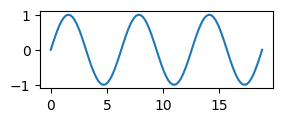

In [ ]:
import matplotlib.pyplot as plt
r = np.linspace(0,6*np.pi,100)
plt.figure(figsize=(3,1))
plt.plot(r,np.sin(r))
plt.show()

You can also do element-wise operations between an arrays.

In [ ]:
r + 2*r

array([ 0.        ,  0.57119866,  1.14239733,  1.71359599,  2.28479466,
        2.85599332,  3.42719199,  3.99839065,  4.56958931,  5.14078798,
        5.71198664,  6.28318531,  6.85438397,  7.42558264,  7.9967813 ,
        8.56797996,  9.13917863,  9.71037729, 10.28157596, 10.85277462,
       11.42397329, 11.99517195, 12.56637061, 13.13756928, 13.70876794,
       14.27996661, 14.85116527, 15.42236394, 15.9935626 , 16.56476126,
       17.13595993, 17.70715859, 18.27835726, 18.84955592, 19.42075459,
       19.99195325, 20.56315191, 21.13435058, 21.70554924, 22.27674791,
       22.84794657, 23.41914524, 23.9903439 , 24.56154256, 25.13274123,
       25.70393989, 26.27513856, 26.84633722, 27.41753589, 27.98873455,
       28.55993321, 29.13113188, 29.70233054, 30.27352921, 30.84472787,
       31.41592654, 31.9871252 , 32.55832386, 33.12952253, 33.70072119,
       34.27191986, 34.84311852, 35.41431719, 35.98551585, 36.55671451,
       37.12791318, 37.69911184, 38.27031051, 38.84150917, 39.41

### ✏️ NumPy Exercises

Practice the vectorized operations above. Do **not** use any `for` loops.
Complete the three exercises below before moving to the Quiz.

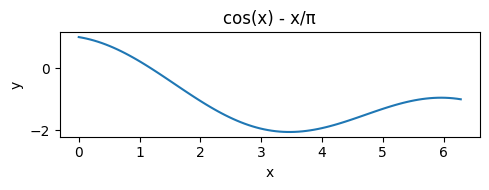

In [1]:
# Exercise 1: Plot a function without a loop
# Create x from 0 to 2π (100 points), compute y = cos(x) - x/π, then plot.
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2*np.pi,100)     # hint: np.linspace
y = np.cos(x)- x/np.pi  # vectorized formula

plt.figure(figsize=(5, 2))
plt.plot(x, y)
plt.xlabel('x'); plt.ylabel('y')
plt.title('cos(x) - x/π')
plt.tight_layout()
plt.show()

In [2]:
# Exercise 2: Vector operations
# Given a and b, compute (without loops):
#   (a) element-wise product
#   (b) dot product (use np.sum or np.dot)
#   (c) magnitude of a: sqrt(a[0]^2 + a[1]^2 + a[2]^2)
a = np.array([1.0, 2.0, 3.0])
b = np.array([4.0, 5.0, 6.0])

element_product = a*b
dot_product     = np.dot(a,b)
magnitude_a     = np.sqrt(np.dot(a,b))   # hint: np.sqrt and np.sum

print(f'Element product: {element_product}')
print(f'Dot product:     {dot_product}')
print(f'|a| =           {magnitude_a:.4f}')

Element product: [ 4. 10. 18.]
Dot product:     32.0
|a| =           5.6569


In [3]:
# Exercise 3: Free-fall position array
# Compute z(t) = v0*t - 0.5*g*t^2 for t in [0, 3] with 1000 points.
# Then find the approximate landing time (when z first crosses zero after launch).
g = 9.8; v0 = 10.0
t = np.linspace(0, 3, 1000)
z = v0*t - 0.5*g*t**2   # vectorized formula

# Find index where z goes negative (after the peak) and estimate landing time
# Hint: z[z > 0] selects positive values; np.argmin picks the minimum index
landing_t = t[np.argmin(z[z>0])]
print(f'Numerical landing time: {landing_t:.3f} s')
print(f'Analytical landing time: {2*v0/g:.3f} s')

Numerical landing time: 2.036 s
Analytical landing time: 2.041 s


## Quiz 2

Plot the ULJ() function without using for loops or list comprehensions. (See Canvas Quiz page for details).

Reminder:

1. we only need np.array() if there is a need to convert a list into an array. If $x$ is already an array, then np.array(x) would be redundant.

2. np.arange() already produces a numpy array


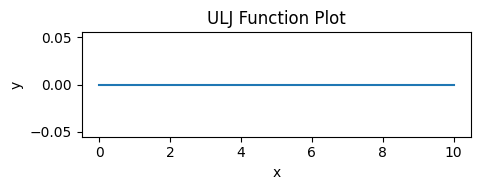

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 100)
y = np.where(x) #some function, can't find the specific funcion on Canvas (unless I'm just supposed to make one up?)

plt.figure(figsize=(5, 2))
plt.plot(x, y)
plt.xlabel('x'); plt.ylabel('y')
plt.title("ULJ Function Plot")
plt.tight_layout()
plt.show()